**Import Libraries**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Import Boo-specific libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.utils import np_utils
from keras.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, normalize

In [54]:
# Import Yunzhou-specific libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

**Set Parameters**

In [55]:
N_STEPS = 10
SPLIT = 0.2
EPOCHS = 200

**Import and Clean Data**

In [57]:
# Import Data
raw_cases_df = pd.read_csv('Data/confirmed_diff.csv')
raw_deaths_df = pd.read_csv('Data/deaths_diff.csv')
raw_mobility_df = pd.read_csv('Data/Google_Mobility.csv')
raw_whole_usa_cases_df = pd.read_csv('Data/us_confirmed_cases.csv')
raw_whole_usa_deaths_df = pd.read_csv('Data/us_confirmed_deaths.csv')

In [58]:
# FOR STATES
# Clean Mobility Data
# mobility_df already contains only those counties and states for which
# complete data on all 6 mobility categories exist
mobility_df = raw_mobility_df.copy()
mobility_df = mobility_df.rename(columns={"retail_and_recreation_percent_change_from_baseline": "retail_and_recreation",
        "grocery_and_pharmacy_percent_change_from_baseline": "grocery_and_pharmacy",
        "parks_percent_change_from_baseline": "parks",
        "transit_stations_percent_change_from_baseline": "transit_stations",
        "workplaces_percent_change_from_baseline": "workplaces",
        "residential_percent_change_from_baseline": "residential"})
# Optional extreme shortening of names
if True:
    mobility_df = mobility_df.rename(columns={"retail_and_recreation": "rr",
            "grocery_and_pharmacy": "gp",
            "transit_stations": "ts",
            "workplaces": "wp",
            "residential": "res"})
# US is the country already, do not need that data
mobility_df.drop(columns=['country_region_code', 'country_region'], inplace=True)
mobility_df.rename(columns={'sub_region_1': 'state', 'sub_region_2': 'county'}, inplace=True)

# Extract all states only data, which have been marked with 'ZZZ' in the county name
state_mobility_df = (mobility_df[mobility_df['county'] == 'ZZZ']).copy()
state_mobility_df.drop(columns=['county'], inplace=True)

In [59]:
# FOR STATES
# Clean Cases Data
cases_df = raw_cases_df.copy()
cases_df.rename(columns={'Admin2': 'county', 'Province_State': 'state', 'Date': 'date', 'Value': 'cases'}, inplace=True)
# Since this is on the state level, county info is not needed
# 'region' and 'diff' are legacy columns that are not needed here
cases_df.drop(columns=['Country_Region', 'county', 'Lat', 'Long_', 'region', 'diff'], inplace=True)
# Sum up cases for each state
state_cases_df = cases_df.groupby(['state', 'date'], as_index=False).agg({'cases':'sum'})

In [60]:
# FOR STATES
# Merge Google Mobility and Cases Data
state_cases_mobility_df = state_cases_df.merge(state_mobility_df, how='inner', on=['state', 'date'])
# Sort to ensure proper order
state_cases_mobility_df['date'] = pd.to_datetime(state_cases_mobility_df['date'], format="%m/%d/%Y")
state_cases_mobility_df.sort_values(['state', 'date'], ascending=[True, True], inplace=True)

In [61]:
# List out all applicable states for later
state_names = ['South Carolina', 'Louisiana', 'Virginia', 'Idaho', 'Iowa',
               'Kentucky', 'Missouri', 'Oklahoma', 'Colorado', 'Illinois',
               'Indiana', 'Mississippi', 'Nebraska', 'North Dakota', 'Ohio',
               'Pennsylvania', 'Washington', 'Wisconsin', 'Vermont', 'Minnesota',
               'Florida', 'North Carolina', 'California', 'New York', 'Wyoming',
               'Michigan', 'Alaska', 'Maryland', 'Kansas', 'Tennessee', 'Texas',
               'Maine', 'Arizona', 'Georgia', 'Arkansas', 'New Jersey',
               'South Dakota', 'Alabama', 'Oregon', 'West Virginia',
               'Massachusetts', 'Utah', 'Montana', 'New Hampshire', 'New Mexico',
               'Rhode Island', 'Nevada', 'District of Columbia', 'Connecticut',
               'Hawaii']
# total of 50 statewide data (49 states + Washington D.C.)
# Missing Delaware
state_names_no_mobility = state_names.copy()
state_names_no_mobility.append('Delaware')


As is, "state_cases_mobility_df" contains confirmed cases data for each state at each point in time, with mobility data.

"state_cases_df" only contains confirmed cases data.

**Transform Data**

*Note that these models all assume,
the underlying trend of cases for each state is the same,
and there are no state-by-state variations in how the disease spreads,
which is likely unrealistic*

In [15]:
# Normalize Data
# Following Boo
# scaler = MinMaxScaler(feature_range=(0,1))
# state_cases_mobility_normalized_df = scaler.fit_transform(state_cases_mobility_df)

In [16]:
# Remember to Split Data into Training and Validation Sets

In [17]:
# Organize Data for LSTM
# Objective is to predict cases for current day given previous N_STEPS days
# However, having multiple states, each as their own individual time series,
# complicates this.
# input should be of shape (n_steps, n_features) with multiple samples

# Modified from Boo's code
def get_LSTM_states_dataset(dataset, n_steps=1):
    dataset = dataset.copy()
    dataset.drop(columns=['date'], inplace=True)
    #print(dataset.shape)
    dataset_by_states = []
    # Normalize data while you are at it
    scaler = MinMaxScaler(feature_range=(0,1))
    for state in dataset['state'].unique():
        state_values = dataset[dataset['state'] == state].drop(columns='state').values
        state_values = scaler.fit_transform(state_values)
        dataset_by_states.append(state_values)
    X, y = [], []
    for state_dataset in dataset_by_states:
        for i in range(len(state_dataset) - n_steps - 1):
            a = state_dataset[i:(i+n_steps)]
            X.append(a)
            y.append(state_dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return X, y

X_LSTM, y_LSTM = get_LSTM_states_dataset(state_cases_mobility_df, n_steps=N_STEPS)
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size=SPLIT, shuffle=False)

In [62]:
# Organize Data for CNN/Regular NN
# Objective is to predict cases for current day given previous N_STEPS days.
# We must add the value of the columns from previous
# days as extra features per observation
def get_CNN_states_dataset(dataset, n_steps=1):
    dataset = dataset.copy()
    dataset.drop(columns=['date'], inplace=True)
    #print(dataset.shape)
    dataset_by_states = []
    # Normalize data while you are at it
    scaler = MinMaxScaler(feature_range=(0,1))
    for state in dataset['state'].unique():
        state_values = dataset[dataset['state'] == state].drop(columns='state').values
        state_values = scaler.fit_transform(state_values)
        dataset_by_states.append(state_values)
    X, y = [], []
    for state_dataset in dataset_by_states:
        for i in range(len(state_dataset) - n_steps - 1):
            a = state_dataset[i:(i+n_steps)]
            X.append(a)
            y.append(state_dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return X, y

X_CNN, y_CNN = get_CNN_states_dataset(state_cases_mobility_df, n_steps=N_STEPS)
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X_CNN, y_CNN, test_size=SPLIT, shuffle=False)

In [63]:
# Organize Data for Yunzhou's NN

def get_YNN_states_dataset(dataset, n_steps=1):
    dataset = dataset.copy()
    dataset.drop(columns=['date'], inplace=True)
    #print(dataset.shape)
    dataset_by_states = []
    # Normalize data while you are at it
    scaler = MinMaxScaler(feature_range=(0,1))
    for state in dataset['state'].unique():
        state_values = dataset[dataset['state'] == state].drop(columns='state').values
        state_values = scaler.fit_transform(state_values)
        dataset_by_states.append(state_values)
    X, y = [], []
    for state_dataset in dataset_by_states:
        for i in range(len(state_dataset) - n_steps - 1):
            a = state_dataset[i:(i+n_steps)]
            # Flatten a, a list of lists, into a single row of features
            flat_a = []
            for sublist in a:
                for item in sublist:
                    flat_a.append(item)
            X.append(flat_a)
            y.append(state_dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return X, y

X_YNN, y_YNN = get_YNN_states_dataset(state_cases_mobility_df, n_steps=N_STEPS)
X_train_YNN, X_test_YNN, y_train_YNN, y_test_YNN = train_test_split(X_YNN, y_YNN, test_size=SPLIT, shuffle=False)

**LSTM Model with Mobility Data**

In [101]:
# Set up LSTM, Boo's model
def get_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = adam, loss='mse', metrics=['mae', 'mse'])
    return model

n_lstm_features = X_train_LSTM.shape[2]
lstm = get_lstm(N_STEPS, n_lstm_features)

In [102]:
# Fit LSTM
lstmhistory = lstm.fit(X_train_LSTM, y_train_LSTM,
                       epochs=EPOCHS,
                       validation_data=(X_test_LSTM, y_test_LSTM),
                       verbose=1,
                       shuffle=False)

Train on 2440 samples, validate on 610 samples
Epoch 1/500
2440/2440 [==============================] - 1s 399us/step - loss: 0.0252 - mae: 0.1046 - mse: 0.0252 - val_loss: 0.0031 - val_mae: 0.0398 - val_mse: 0.0031
Epoch 2/500
2440/2440 [==============================] - 1s 300us/step - loss: 0.0024 - mae: 0.0347 - mse: 0.0024 - val_loss: 0.0019 - val_mae: 0.0282 - val_mse: 0.0019
Epoch 3/500
2440/2440 [==============================] - 1s 292us/step - loss: 0.0018 - mae: 0.0315 - mse: 0.0018 - val_loss: 0.0015 - val_mae: 0.0269 - val_mse: 0.0015
Epoch 4/500
2440/2440 [==============================] - 1s 273us/step - loss: 0.0014 - mae: 0.0269 - mse: 0.0014 - val_loss: 0.0014 - val_mae: 0.0237 - val_mse: 0.0014
Epoch 5/500
2440/2440 [==============================] - 1s 266us/step - loss: 0.0012 - mae: 0.0249 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0227 - val_mse: 0.0012
Epoch 6/500
2440/2440 [==============================] - 1s 282us/step - loss: 0.0011 - mae: 0.0233 - mse: 0

Epoch 89/500
2440/2440 [==============================] - 1s 288us/step - loss: 1.5454e-04 - mae: 0.0079 - mse: 1.5454e-04 - val_loss: 2.1646e-04 - val_mae: 0.0077 - val_mse: 2.1646e-04
Epoch 90/500
2440/2440 [==============================] - 1s 286us/step - loss: 1.5427e-04 - mae: 0.0079 - mse: 1.5427e-04 - val_loss: 2.1707e-04 - val_mae: 0.0078 - val_mse: 2.1707e-04
Epoch 91/500
2440/2440 [==============================] - 1s 298us/step - loss: 1.5406e-04 - mae: 0.0079 - mse: 1.5406e-04 - val_loss: 2.1826e-04 - val_mae: 0.0080 - val_mse: 2.1826e-04
Epoch 92/500
2440/2440 [==============================] - 1s 299us/step - loss: 1.5391e-04 - mae: 0.0079 - mse: 1.5391e-04 - val_loss: 2.2018e-04 - val_mae: 0.0082 - val_mse: 2.2018e-04
Epoch 93/500
2440/2440 [==============================] - 1s 289us/step - loss: 1.5381e-04 - mae: 0.0079 - mse: 1.5381e-04 - val_loss: 2.2294e-04 - val_mae: 0.0085 - val_mse: 2.2294e-04
Epoch 94/500
2440/2440 [==============================] - 1s 299us/ste

Epoch 133/500
2440/2440 [==============================] - 1s 285us/step - loss: 1.4803e-04 - mae: 0.0078 - mse: 1.4803e-04 - val_loss: 2.1443e-04 - val_mae: 0.0080 - val_mse: 2.1443e-04
Epoch 134/500
2440/2440 [==============================] - 1s 278us/step - loss: 1.4779e-04 - mae: 0.0078 - mse: 1.4779e-04 - val_loss: 2.1429e-04 - val_mae: 0.0080 - val_mse: 2.1429e-04
Epoch 135/500
2440/2440 [==============================] - 1s 306us/step - loss: 1.4749e-04 - mae: 0.0077 - mse: 1.4749e-04 - val_loss: 2.1412e-04 - val_mae: 0.0080 - val_mse: 2.1412e-04
Epoch 136/500
2440/2440 [==============================] - 1s 281us/step - loss: 1.4719e-04 - mae: 0.0077 - mse: 1.4719e-04 - val_loss: 2.1397e-04 - val_mae: 0.0080 - val_mse: 2.1397e-04
Epoch 137/500
2440/2440 [==============================] - 1s 279us/step - loss: 1.4691e-04 - mae: 0.0077 - mse: 1.4691e-04 - val_loss: 2.1389e-04 - val_mae: 0.0080 - val_mse: 2.1389e-04
Epoch 138/500
2440/2440 [==============================] - 1s 281

Epoch 177/500
2440/2440 [==============================] - 1s 286us/step - loss: 1.3755e-04 - mae: 0.0076 - mse: 1.3755e-04 - val_loss: 2.1394e-04 - val_mae: 0.0079 - val_mse: 2.1394e-04
Epoch 178/500
2440/2440 [==============================] - 1s 282us/step - loss: 1.3754e-04 - mae: 0.0077 - mse: 1.3754e-04 - val_loss: 2.1456e-04 - val_mae: 0.0079 - val_mse: 2.1456e-04
Epoch 179/500
2440/2440 [==============================] - 1s 273us/step - loss: 1.3756e-04 - mae: 0.0077 - mse: 1.3756e-04 - val_loss: 2.1515e-04 - val_mae: 0.0079 - val_mse: 2.1515e-04
Epoch 180/500
2440/2440 [==============================] - 1s 270us/step - loss: 1.3761e-04 - mae: 0.0077 - mse: 1.3761e-04 - val_loss: 2.1567e-04 - val_mae: 0.0079 - val_mse: 2.1567e-04
Epoch 181/500
2440/2440 [==============================] - 1s 274us/step - loss: 1.3771e-04 - mae: 0.0077 - mse: 1.3771e-04 - val_loss: 2.1607e-04 - val_mae: 0.0079 - val_mse: 2.1607e-04
Epoch 182/500
2440/2440 [==============================] - 1s 279

Epoch 221/500
2440/2440 [==============================] - 1s 277us/step - loss: 1.2938e-04 - mae: 0.0073 - mse: 1.2938e-04 - val_loss: 2.1146e-04 - val_mae: 0.0076 - val_mse: 2.1146e-04
Epoch 222/500
2440/2440 [==============================] - 1s 270us/step - loss: 1.2762e-04 - mae: 0.0072 - mse: 1.2762e-04 - val_loss: 2.1086e-04 - val_mae: 0.0076 - val_mse: 2.1086e-04
Epoch 223/500
2440/2440 [==============================] - 1s 278us/step - loss: 1.2577e-04 - mae: 0.0071 - mse: 1.2577e-04 - val_loss: 2.1093e-04 - val_mae: 0.0077 - val_mse: 2.1093e-04
Epoch 224/500
2440/2440 [==============================] - 1s 285us/step - loss: 1.2404e-04 - mae: 0.0070 - mse: 1.2404e-04 - val_loss: 2.1153e-04 - val_mae: 0.0077 - val_mse: 2.1153e-04
Epoch 225/500
2440/2440 [==============================] - 1s 322us/step - loss: 1.2252e-04 - mae: 0.0069 - mse: 1.2252e-04 - val_loss: 2.1250e-04 - val_mae: 0.0077 - val_mse: 2.1250e-04
Epoch 226/500
2440/2440 [==============================] - 1s 305

2440/2440 [==============================] - 1s 280us/step - loss: 1.1711e-04 - mae: 0.0073 - mse: 1.1711e-04 - val_loss: 2.7475e-04 - val_mae: 0.0093 - val_mse: 2.7475e-04
Epoch 308/500
2440/2440 [==============================] - 1s 272us/step - loss: 1.1935e-04 - mae: 0.0074 - mse: 1.1935e-04 - val_loss: 2.6739e-04 - val_mae: 0.0089 - val_mse: 2.6739e-04
Epoch 309/500
2440/2440 [==============================] - 1s 297us/step - loss: 1.1334e-04 - mae: 0.0069 - mse: 1.1334e-04 - val_loss: 2.4911e-04 - val_mae: 0.0083 - val_mse: 2.4911e-04
Epoch 310/500
2440/2440 [==============================] - 1s 279us/step - loss: 1.1226e-04 - mae: 0.0068 - mse: 1.1226e-04 - val_loss: 2.3343e-04 - val_mae: 0.0084 - val_mse: 2.3343e-04
Epoch 311/500
2440/2440 [==============================] - 1s 272us/step - loss: 1.1090e-04 - mae: 0.0067 - mse: 1.1090e-04 - val_loss: 2.3534e-04 - val_mae: 0.0087 - val_mse: 2.3534e-04
Epoch 312/500
2440/2440 [==============================] - 1s 274us/step - loss

Epoch 351/500
2440/2440 [==============================] - 1s 285us/step - loss: 1.0776e-04 - mae: 0.0070 - mse: 1.0776e-04 - val_loss: 2.9247e-04 - val_mae: 0.0112 - val_mse: 2.9247e-04
Epoch 352/500
2440/2440 [==============================] - 1s 293us/step - loss: 1.0654e-04 - mae: 0.0070 - mse: 1.0654e-04 - val_loss: 2.8964e-04 - val_mae: 0.0110 - val_mse: 2.8964e-04
Epoch 353/500
2440/2440 [==============================] - 1s 273us/step - loss: 1.0504e-04 - mae: 0.0068 - mse: 1.0504e-04 - val_loss: 2.8622e-04 - val_mae: 0.0105 - val_mse: 2.8622e-04
Epoch 354/500
2440/2440 [==============================] - 1s 276us/step - loss: 1.0642e-04 - mae: 0.0068 - mse: 1.0642e-04 - val_loss: 2.8711e-04 - val_mae: 0.0099 - val_mse: 2.8711e-04
Epoch 355/500
2440/2440 [==============================] - 1s 275us/step - loss: 1.0692e-04 - mae: 0.0069 - mse: 1.0692e-04 - val_loss: 2.8345e-04 - val_mae: 0.0095 - val_mse: 2.8345e-04
Epoch 356/500
2440/2440 [==============================] - 1s 277

Epoch 395/500
2440/2440 [==============================] - 1s 263us/step - loss: 9.8032e-05 - mae: 0.0068 - mse: 9.8032e-05 - val_loss: 3.0700e-04 - val_mae: 0.0097 - val_mse: 3.0700e-04
Epoch 396/500
2440/2440 [==============================] - 1s 278us/step - loss: 9.5973e-05 - mae: 0.0067 - mse: 9.5973e-05 - val_loss: 3.0652e-04 - val_mae: 0.0095 - val_mse: 3.0652e-04
Epoch 397/500
2440/2440 [==============================] - 1s 272us/step - loss: 9.4194e-05 - mae: 0.0066 - mse: 9.4194e-05 - val_loss: 3.0609e-04 - val_mae: 0.0093 - val_mse: 3.0609e-04
Epoch 398/500
2440/2440 [==============================] - 1s 268us/step - loss: 9.2076e-05 - mae: 0.0064 - mse: 9.2076e-05 - val_loss: 3.0584e-04 - val_mae: 0.0092 - val_mse: 3.0584e-04
Epoch 399/500
2440/2440 [==============================] - 1s 263us/step - loss: 9.0494e-05 - mae: 0.0063 - mse: 9.0494e-05 - val_loss: 3.0591e-04 - val_mae: 0.0092 - val_mse: 3.0591e-04
Epoch 400/500
2440/2440 [==============================] - 1s 264

Epoch 439/500
2440/2440 [==============================] - 1s 278us/step - loss: 9.2455e-05 - mae: 0.0065 - mse: 9.2455e-05 - val_loss: 3.2848e-04 - val_mae: 0.0099 - val_mse: 3.2848e-04
Epoch 440/500
2440/2440 [==============================] - 1s 336us/step - loss: 9.3698e-05 - mae: 0.0066 - mse: 9.3698e-05 - val_loss: 3.2057e-04 - val_mae: 0.0098 - val_mse: 3.2057e-04
Epoch 441/500
2440/2440 [==============================] - 1s 294us/step - loss: 8.6396e-05 - mae: 0.0064 - mse: 8.6397e-05 - val_loss: 3.6014e-04 - val_mae: 0.0106 - val_mse: 3.6014e-04
Epoch 442/500
2440/2440 [==============================] - 1s 396us/step - loss: 9.6028e-05 - mae: 0.0069 - mse: 9.6028e-05 - val_loss: 3.4149e-04 - val_mae: 0.0108 - val_mse: 3.4149e-04
Epoch 443/500
2440/2440 [==============================] - 1s 329us/step - loss: 9.7392e-05 - mae: 0.0068 - mse: 9.7392e-05 - val_loss: 3.2756e-04 - val_mae: 0.0098 - val_mse: 3.2756e-04
Epoch 444/500
2440/2440 [==============================] - 1s 291

Epoch 483/500
2440/2440 [==============================] - 1s 293us/step - loss: 7.5337e-05 - mae: 0.0061 - mse: 7.5337e-05 - val_loss: 3.8486e-04 - val_mae: 0.0108 - val_mse: 3.8486e-04
Epoch 484/500
2440/2440 [==============================] - 1s 283us/step - loss: 7.6622e-05 - mae: 0.0061 - mse: 7.6622e-05 - val_loss: 4.0465e-04 - val_mae: 0.0112 - val_mse: 4.0465e-04
Epoch 485/500
2440/2440 [==============================] - 1s 278us/step - loss: 8.3597e-05 - mae: 0.0065 - mse: 8.3597e-05 - val_loss: 4.0550e-04 - val_mae: 0.0113 - val_mse: 4.0550e-04
Epoch 486/500
2440/2440 [==============================] - 1s 278us/step - loss: 9.0490e-05 - mae: 0.0068 - mse: 9.0490e-05 - val_loss: 4.5308e-04 - val_mae: 0.0116 - val_mse: 4.5308e-04
Epoch 487/500
2440/2440 [==============================] - 1s 287us/step - loss: 8.2534e-05 - mae: 0.0065 - mse: 8.2534e-05 - val_loss: 3.9571e-04 - val_mae: 0.0107 - val_mse: 3.9571e-04
Epoch 488/500
2440/2440 [==============================] - 1s 281

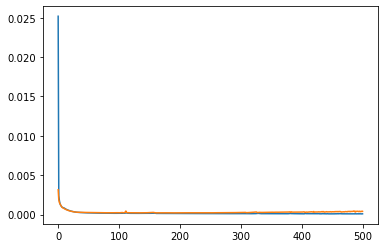

In [105]:
# Graph LSTM Error, mae and mse
plt.plot(lstmhistory.history['loss'])
plt.plot(lstmhistory.history['val_loss'])


**LSTM Model WITHOUT Mobility Data**

In [110]:
# Get data
X_LSTM_nomob, y_LSTM_nomob = get_LSTM_states_dataset(state_cases_df, n_steps=N_STEPS)
X_train_LSTM_nomob, X_test_LSTM_nomob, y_train_LSTM_nomob, y_test_LSTM_nomob = train_test_split(X_LSTM_nomob, y_LSTM_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_lstm_features = X_train_LSTM_nomob.shape[2]
lstm_nomob = get_lstm(N_STEPS, n_lstm_features)

# Fit LSTM
lstm_nomob_history = lstm_nomob.fit(X_train_LSTM_nomob, y_train_LSTM_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_LSTM_nomob, y_test_LSTM_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/500
4222/4222 [==============================] - 1s 323us/step - loss: 0.0301 - mae: 0.1085 - mse: 0.0301 - val_loss: 0.0233 - val_mae: 0.0937 - val_mse: 0.0233
Epoch 2/500
4222/4222 [==============================] - 1s 253us/step - loss: 0.0224 - mae: 0.0810 - mse: 0.0224 - val_loss: 0.0199 - val_mae: 0.0780 - val_mse: 0.0199
Epoch 3/500
4222/4222 [==============================] - 1s 251us/step - loss: 0.0197 - mae: 0.0703 - mse: 0.0197 - val_loss: 0.0184 - val_mae: 0.0735 - val_mse: 0.0184
Epoch 4/500
4222/4222 [==============================] - 1s 246us/step - loss: 0.0183 - mae: 0.0664 - mse: 0.0183 - val_loss: 0.0170 - val_mae: 0.0720 - val_mse: 0.0170
Epoch 5/500
4222/4222 [==============================] - 1s 260us/step - loss: 0.0167 - mae: 0.0632 - mse: 0.0167 - val_loss: 0.0149 - val_mae: 0.0651 - val_mse: 0.0149
Epoch 6/500
4222/4222 [==============================] - 1s 246us/step - loss: 0.0156 - mae: 0.0620 - mse: 

Epoch 49/500
4222/4222 [==============================] - 1s 286us/step - loss: 0.0052 - mae: 0.0329 - mse: 0.0052 - val_loss: 0.0080 - val_mae: 0.0418 - val_mse: 0.0080
Epoch 50/500
4222/4222 [==============================] - 1s 273us/step - loss: 0.0052 - mae: 0.0329 - mse: 0.0052 - val_loss: 0.0074 - val_mae: 0.0399 - val_mse: 0.0074
Epoch 51/500
4222/4222 [==============================] - 1s 274us/step - loss: 0.0048 - mae: 0.0317 - mse: 0.0048 - val_loss: 0.0079 - val_mae: 0.0411 - val_mse: 0.0079
Epoch 52/500
4222/4222 [==============================] - 1s 283us/step - loss: 0.0047 - mae: 0.0313 - mse: 0.0047 - val_loss: 0.0077 - val_mae: 0.0400 - val_mse: 0.0077
Epoch 53/500
4222/4222 [==============================] - 1s 309us/step - loss: 0.0044 - mae: 0.0304 - mse: 0.0044 - val_loss: 0.0076 - val_mae: 0.0394 - val_mse: 0.0076
Epoch 54/500
4222/4222 [==============================] - 1s 279us/step - loss: 0.0042 - mae: 0.0297 - mse: 0.0042 - val_loss: 0.0073 - val_mae: 0.038

4222/4222 [==============================] - 1s 283us/step - loss: 0.0013 - mae: 0.0152 - mse: 0.0013 - val_loss: 0.0026 - val_mae: 0.0199 - val_mse: 0.0026
Epoch 146/500
4222/4222 [==============================] - 1s 286us/step - loss: 0.0020 - mae: 0.0189 - mse: 0.0020 - val_loss: 0.0032 - val_mae: 0.0205 - val_mse: 0.0032
Epoch 147/500
4222/4222 [==============================] - 1s 291us/step - loss: 0.0012 - mae: 0.0151 - mse: 0.0012 - val_loss: 0.0026 - val_mae: 0.0205 - val_mse: 0.0026
Epoch 148/500
4222/4222 [==============================] - 1s 333us/step - loss: 0.0019 - mae: 0.0184 - mse: 0.0019 - val_loss: 0.0027 - val_mae: 0.0201 - val_mse: 0.0027
Epoch 149/500
4222/4222 [==============================] - 1s 285us/step - loss: 0.0013 - mae: 0.0149 - mse: 0.0013 - val_loss: 0.0026 - val_mae: 0.0209 - val_mse: 0.0026
Epoch 150/500
4222/4222 [==============================] - 1s 299us/step - loss: 0.0019 - mae: 0.0187 - mse: 0.0019 - val_loss: 0.0032 - val_mae: 0.0206 - val_

KeyboardInterrupt: 

In [157]:
# Graph LSTM Error, mae and mse
plt.plot(lstm_nomob_history.history['loss'])
plt.plot(lstm_nomob_history.history['val_loss'])


NameError: name 'lstm_nomob_history' is not defined

**STACKED LSTM Model with Mobility Data**

In [114]:
# Set up Stacked LSTM, Boo's model
def get_stacked_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

n_lstm_features = X_train_LSTM.shape[2]
slstm = get_stacked_lstm(N_STEPS, n_lstm_features)

In [115]:
# Use same data from earlier to fit the model
slstmhistory = slstm.fit(X_train_LSTM, y_train_LSTM,
                       epochs=EPOCHS,
                       validation_data=(X_test_LSTM, y_test_LSTM),
                       verbose=1,
                       shuffle=False)


Train on 2440 samples, validate on 610 samples
Epoch 1/200
2440/2440 [==============================] - 2s 785us/step - loss: 0.0174 - mae: 0.0798 - mse: 0.0174 - val_loss: 0.0022 - val_mae: 0.0349 - val_mse: 0.0022
Epoch 2/200
2440/2440 [==============================] - 1s 543us/step - loss: 0.0022 - mae: 0.0343 - mse: 0.0022 - val_loss: 0.0024 - val_mae: 0.0412 - val_mse: 0.0024
Epoch 3/200
2440/2440 [==============================] - 1s 549us/step - loss: 0.0017 - mae: 0.0310 - mse: 0.0017 - val_loss: 0.0015 - val_mae: 0.0299 - val_mse: 0.0015
Epoch 4/200
2440/2440 [==============================] - 1s 562us/step - loss: 0.0015 - mae: 0.0279 - mse: 0.0015 - val_loss: 0.0013 - val_mae: 0.0278 - val_mse: 0.0013
Epoch 5/200
2440/2440 [==============================] - 1s 537us/step - loss: 0.0014 - mae: 0.0272 - mse: 0.0014 - val_loss: 0.0015 - val_mae: 0.0328 - val_mse: 0.0015
Epoch 6/200
2440/2440 [==============================] - 1s 538us/step - loss: 0.0013 - mae: 0.0256 - mse: 0

2440/2440 [==============================] - 1s 597us/step - loss: 1.7867e-04 - mae: 0.0089 - mse: 1.7867e-04 - val_loss: 2.1307e-04 - val_mae: 0.0079 - val_mse: 2.1307e-04
Epoch 90/200
2440/2440 [==============================] - 1s 596us/step - loss: 1.7908e-04 - mae: 0.0089 - mse: 1.7908e-04 - val_loss: 2.1328e-04 - val_mae: 0.0080 - val_mse: 2.1328e-04
Epoch 91/200
2440/2440 [==============================] - 1s 611us/step - loss: 1.7892e-04 - mae: 0.0089 - mse: 1.7892e-04 - val_loss: 2.1301e-04 - val_mae: 0.0080 - val_mse: 2.1301e-04
Epoch 92/200
2440/2440 [==============================] - 1s 609us/step - loss: 1.7805e-04 - mae: 0.0089 - mse: 1.7805e-04 - val_loss: 2.1243e-04 - val_mae: 0.0080 - val_mse: 2.1243e-04
Epoch 93/200
2440/2440 [==============================] - 2s 625us/step - loss: 1.7671e-04 - mae: 0.0088 - mse: 1.7671e-04 - val_loss: 2.1182e-04 - val_mae: 0.0080 - val_mse: 2.1182e-04
Epoch 94/200
2440/2440 [==============================] - 1s 611us/step - loss: 1.7

Epoch 133/200
2440/2440 [==============================] - 2s 656us/step - loss: 1.7691e-04 - mae: 0.0090 - mse: 1.7691e-04 - val_loss: 2.0746e-04 - val_mae: 0.0076 - val_mse: 2.0746e-04
Epoch 134/200
2440/2440 [==============================] - 2s 682us/step - loss: 1.7496e-04 - mae: 0.0090 - mse: 1.7496e-04 - val_loss: 2.0820e-04 - val_mae: 0.0076 - val_mse: 2.0820e-04
Epoch 135/200
2440/2440 [==============================] - 1s 600us/step - loss: 1.7299e-04 - mae: 0.0089 - mse: 1.7299e-04 - val_loss: 2.0894e-04 - val_mae: 0.0076 - val_mse: 2.0894e-04
Epoch 136/200
2440/2440 [==============================] - 1s 603us/step - loss: 1.7137e-04 - mae: 0.0088 - mse: 1.7137e-04 - val_loss: 2.0958e-04 - val_mae: 0.0077 - val_mse: 2.0958e-04
Epoch 137/200
2440/2440 [==============================] - 1s 596us/step - loss: 1.7013e-04 - mae: 0.0088 - mse: 1.7013e-04 - val_loss: 2.1011e-04 - val_mae: 0.0077 - val_mse: 2.1011e-04
Epoch 138/200
2440/2440 [==============================] - 1s 593

Epoch 177/200
2440/2440 [==============================] - 1s 610us/step - loss: 1.6032e-04 - mae: 0.0083 - mse: 1.6032e-04 - val_loss: 2.1951e-04 - val_mae: 0.0080 - val_mse: 2.1951e-04
Epoch 178/200
2440/2440 [==============================] - 1s 609us/step - loss: 1.6007e-04 - mae: 0.0083 - mse: 1.6007e-04 - val_loss: 2.1976e-04 - val_mae: 0.0080 - val_mse: 2.1976e-04
Epoch 179/200
2440/2440 [==============================] - 1s 609us/step - loss: 1.5979e-04 - mae: 0.0082 - mse: 1.5979e-04 - val_loss: 2.1935e-04 - val_mae: 0.0080 - val_mse: 2.1935e-04
Epoch 180/200
2440/2440 [==============================] - 2s 674us/step - loss: 1.5937e-04 - mae: 0.0082 - mse: 1.5937e-04 - val_loss: 2.1880e-04 - val_mae: 0.0080 - val_mse: 2.1880e-04
Epoch 181/200
2440/2440 [==============================] - 1s 602us/step - loss: 1.5886e-04 - mae: 0.0082 - mse: 1.5886e-04 - val_loss: 2.1872e-04 - val_mae: 0.0080 - val_mse: 2.1872e-04
Epoch 182/200
2440/2440 [==============================] - 1s 599

**Stacked LSTM Model WITHOUT Mobility Data**

In [159]:
# Reuse No-mobility Data
# X_LSTM_nomob, y_LSTM_nomob = get_LSTM_states_dataset(state_cases_df, n_steps=N_STEPS)
# X_train_LSTM_nomob, X_test_LSTM_nomob, y_train_LSTM_nomob, y_test_LSTM_nomob = train_test_split(X_LSTM_nomob, y_LSTM_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_lstm_features = X_train_LSTM_nomob.shape[2]
slstm_nomob = get_lstm(N_STEPS, n_lstm_features)

# Fit LSTM
slstm_nomob_history = slstm_nomob.fit(X_train_LSTM_nomob, y_train_LSTM_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_LSTM_nomob, y_test_LSTM_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 1s 328us/step - loss: 0.0335 - mae: 0.1160 - mse: 0.0335 - val_loss: 0.0243 - val_mae: 0.0976 - val_mse: 0.0243
Epoch 2/200
4222/4222 [==============================] - 1s 248us/step - loss: 0.0229 - mae: 0.0836 - mse: 0.0229 - val_loss: 0.0203 - val_mae: 0.0802 - val_mse: 0.0203
Epoch 3/200
4222/4222 [==============================] - 1s 243us/step - loss: 0.0197 - mae: 0.0712 - mse: 0.0197 - val_loss: 0.0183 - val_mae: 0.0719 - val_mse: 0.0183
Epoch 4/200
4222/4222 [==============================] - 1s 243us/step - loss: 0.0183 - mae: 0.0670 - mse: 0.0183 - val_loss: 0.0166 - val_mae: 0.0696 - val_mse: 0.0166
Epoch 5/200
4222/4222 [==============================] - 1s 250us/step - loss: 0.0168 - mae: 0.0640 - mse: 0.0168 - val_loss: 0.0150 - val_mae: 0.0691 - val_mse: 0.0150
Epoch 6/200
4222/4222 [==============================] - 1s 262us/step - loss: 0.0158 - mae: 0.0616 - mse: 

Epoch 49/200
4222/4222 [==============================] - 1s 286us/step - loss: 0.0051 - mae: 0.0328 - mse: 0.0051 - val_loss: 0.0059 - val_mae: 0.0398 - val_mse: 0.0059
Epoch 50/200
1088/4222 [======>.......................] - ETA: 0s - loss: 0.0069 - mae: 0.0346 - mse: 0.0069    

KeyboardInterrupt: 

**CNN Model with Mobility Data**

In [152]:
# Set up CNN, Boo's model
def get_CNN_model(n_steps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, 
                     activation='relu', 
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

n_CNN_features = X_train_CNN.shape[2]
cnn = get_CNN_model(N_STEPS, n_CNN_features)

In [153]:
# Fit CNN
cnnhistory = cnn.fit(X_train_CNN, y_train_CNN,
                       epochs=EPOCHS,
                       validation_data=(X_test_CNN, y_test_CNN),
                       verbose=1,
                       shuffle=False)

Train on 2440 samples, validate on 610 samples
Epoch 1/200
2440/2440 [==============================] - 0s 108us/step - loss: 0.0267 - mae: 0.1135 - mse: 0.0267 - val_loss: 0.0038 - val_mae: 0.0474 - val_mse: 0.0038
Epoch 2/200
2440/2440 [==============================] - 0s 65us/step - loss: 0.0034 - mae: 0.0444 - mse: 0.0034 - val_loss: 0.0024 - val_mae: 0.0364 - val_mse: 0.0024
Epoch 3/200
2440/2440 [==============================] - 0s 59us/step - loss: 0.0024 - mae: 0.0375 - mse: 0.0024 - val_loss: 0.0020 - val_mae: 0.0317 - val_mse: 0.0020
Epoch 4/200
2440/2440 [==============================] - 0s 57us/step - loss: 0.0020 - mae: 0.0337 - mse: 0.0020 - val_loss: 0.0018 - val_mae: 0.0304 - val_mse: 0.0018
Epoch 5/200
2440/2440 [==============================] - 0s 66us/step - loss: 0.0016 - mae: 0.0303 - mse: 0.0016 - val_loss: 0.0016 - val_mae: 0.0290 - val_mse: 0.0016
Epoch 6/200
2440/2440 [==============================] - 0s 58us/step - loss: 0.0015 - mae: 0.0286 - mse: 0.0015

2440/2440 [==============================] - 0s 57us/step - loss: 2.1775e-04 - mae: 0.0106 - mse: 2.1775e-04 - val_loss: 8.6006e-04 - val_mae: 0.0211 - val_mse: 8.6006e-04
Epoch 91/200
2440/2440 [==============================] - 0s 56us/step - loss: 2.0336e-04 - mae: 0.0103 - mse: 2.0336e-04 - val_loss: 8.6102e-04 - val_mae: 0.0211 - val_mse: 8.6102e-04
Epoch 92/200
2440/2440 [==============================] - 0s 62us/step - loss: 1.9837e-04 - mae: 0.0102 - mse: 1.9837e-04 - val_loss: 8.9843e-04 - val_mae: 0.0214 - val_mse: 8.9843e-04
Epoch 93/200
2440/2440 [==============================] - 0s 52us/step - loss: 2.0191e-04 - mae: 0.0106 - mse: 2.0191e-04 - val_loss: 9.3765e-04 - val_mae: 0.0216 - val_mse: 9.3765e-04
Epoch 94/200
2440/2440 [==============================] - 0s 54us/step - loss: 2.2001e-04 - mae: 0.0111 - mse: 2.2001e-04 - val_loss: 9.5735e-04 - val_mae: 0.0214 - val_mse: 9.5735e-04
Epoch 95/200
2440/2440 [==============================] - 0s 54us/step - loss: 2.3568e-0

2440/2440 [==============================] - 0s 61us/step - loss: 2.6295e-04 - mae: 0.0109 - mse: 2.6295e-04 - val_loss: 7.8051e-04 - val_mae: 0.0194 - val_mse: 7.8051e-04
Epoch 136/200
2440/2440 [==============================] - 0s 59us/step - loss: 2.5333e-04 - mae: 0.0107 - mse: 2.5333e-04 - val_loss: 7.9060e-04 - val_mae: 0.0196 - val_mse: 7.9060e-04
Epoch 137/200
2440/2440 [==============================] - 0s 55us/step - loss: 2.4360e-04 - mae: 0.0105 - mse: 2.4360e-04 - val_loss: 8.0171e-04 - val_mae: 0.0197 - val_mse: 8.0171e-04
Epoch 138/200
2440/2440 [==============================] - 0s 54us/step - loss: 2.3937e-04 - mae: 0.0104 - mse: 2.3937e-04 - val_loss: 8.1011e-04 - val_mae: 0.0197 - val_mse: 8.1011e-04
Epoch 139/200
2440/2440 [==============================] - 0s 56us/step - loss: 2.3558e-04 - mae: 0.0103 - mse: 2.3558e-04 - val_loss: 8.2549e-04 - val_mae: 0.0199 - val_mse: 8.2549e-04
Epoch 140/200
2440/2440 [==============================] - 0s 56us/step - loss: 2.29

Epoch 180/200
2440/2440 [==============================] - 0s 59us/step - loss: 1.6284e-04 - mae: 0.0087 - mse: 1.6284e-04 - val_loss: 7.2596e-04 - val_mae: 0.0163 - val_mse: 7.2596e-04
Epoch 181/200
2440/2440 [==============================] - 0s 52us/step - loss: 1.5364e-04 - mae: 0.0084 - mse: 1.5364e-04 - val_loss: 7.1443e-04 - val_mae: 0.0162 - val_mse: 7.1443e-04
Epoch 182/200
2440/2440 [==============================] - 0s 50us/step - loss: 1.4952e-04 - mae: 0.0083 - mse: 1.4952e-04 - val_loss: 7.1289e-04 - val_mae: 0.0163 - val_mse: 7.1289e-04
Epoch 183/200
2440/2440 [==============================] - 0s 52us/step - loss: 1.4290e-04 - mae: 0.0081 - mse: 1.4290e-04 - val_loss: 7.1534e-04 - val_mae: 0.0163 - val_mse: 7.1534e-04
Epoch 184/200
2440/2440 [==============================] - 0s 50us/step - loss: 1.3574e-04 - mae: 0.0079 - mse: 1.3574e-04 - val_loss: 7.1468e-04 - val_mae: 0.0163 - val_mse: 7.1468e-04
Epoch 185/200
2440/2440 [==============================] - 0s 56us/ste

In [ ]:
# Graph CNN Error, mae and mse

**CNN Model WITHOUT Mobility Data**

In [172]:
# Get data
X_CNN_nomob, y_CNN_nomob = get_CNN_states_dataset(state_cases_df, n_steps=N_STEPS)
X_train_CNN_nomob, X_test_CNN_nomob, y_train_CNN_nomob, y_test_CNN_nomob = train_test_split(X_CNN_nomob, y_CNN_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_cnn_features = X_train_CNN_nomob.shape[2]
cnn_nomob = get_CNN_model(N_STEPS, n_cnn_features)

# Fit CNN
cnn_nomob_history = cnn_nomob.fit(X_train_CNN_nomob, y_train_CNN_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_CNN_nomob, y_test_CNN_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 0s 74us/step - loss: 0.0293 - mae: 0.1033 - mse: 0.0293 - val_loss: 0.0145 - val_mae: 0.0674 - val_mse: 0.0145
Epoch 2/200
4222/4222 [==============================] - 0s 46us/step - loss: 0.0145 - mae: 0.0632 - mse: 0.0145 - val_loss: 0.0122 - val_mae: 0.0598 - val_mse: 0.0122
Epoch 3/200
4222/4222 [==============================] - 0s 54us/step - loss: 0.0133 - mae: 0.0587 - mse: 0.0133 - val_loss: 0.0115 - val_mae: 0.0586 - val_mse: 0.0115
Epoch 4/200
4222/4222 [==============================] - 0s 48us/step - loss: 0.0127 - mae: 0.0572 - mse: 0.0127 - val_loss: 0.0109 - val_mae: 0.0582 - val_mse: 0.0109
Epoch 5/200
4222/4222 [==============================] - 0s 51us/step - loss: 0.0122 - mae: 0.0558 - mse: 0.0122 - val_loss: 0.0106 - val_mae: 0.0599 - val_mse: 0.0106
Epoch 6/200
4222/4222 [==============================] - 0s 47us/step - loss: 0.0118 - mae: 0.0544 - mse: 0.0118

4222/4222 [==============================] - 0s 65us/step - loss: 0.0055 - mae: 0.0317 - mse: 0.0055 - val_loss: 0.0057 - val_mae: 0.0363 - val_mse: 0.0057
Epoch 98/200
4222/4222 [==============================] - 0s 43us/step - loss: 0.0055 - mae: 0.0316 - mse: 0.0055 - val_loss: 0.0057 - val_mae: 0.0362 - val_mse: 0.0057
Epoch 99/200
4222/4222 [==============================] - 0s 46us/step - loss: 0.0055 - mae: 0.0321 - mse: 0.0055 - val_loss: 0.0057 - val_mae: 0.0346 - val_mse: 0.0057
Epoch 100/200
4222/4222 [==============================] - 0s 44us/step - loss: 0.0055 - mae: 0.0314 - mse: 0.0055 - val_loss: 0.0057 - val_mae: 0.0353 - val_mse: 0.0057
Epoch 101/200
4222/4222 [==============================] - 0s 44us/step - loss: 0.0055 - mae: 0.0313 - mse: 0.0055 - val_loss: 0.0057 - val_mae: 0.0362 - val_mse: 0.0057
Epoch 102/200
4222/4222 [==============================] - 0s 45us/step - loss: 0.0055 - mae: 0.0311 - mse: 0.0055 - val_loss: 0.0057 - val_mae: 0.0345 - val_mse: 0.0

4222/4222 [==============================] - 0s 46us/step - loss: 0.0050 - mae: 0.0288 - mse: 0.0050 - val_loss: 0.0057 - val_mae: 0.0356 - val_mse: 0.0057
Epoch 194/200
4222/4222 [==============================] - 0s 47us/step - loss: 0.0050 - mae: 0.0288 - mse: 0.0050 - val_loss: 0.0057 - val_mae: 0.0350 - val_mse: 0.0057
Epoch 195/200
4222/4222 [==============================] - 0s 43us/step - loss: 0.0051 - mae: 0.0289 - mse: 0.0051 - val_loss: 0.0057 - val_mae: 0.0353 - val_mse: 0.0057
Epoch 196/200
4222/4222 [==============================] - 0s 45us/step - loss: 0.0050 - mae: 0.0287 - mse: 0.0050 - val_loss: 0.0056 - val_mae: 0.0349 - val_mse: 0.0056
Epoch 197/200
4222/4222 [==============================] - 0s 44us/step - loss: 0.0050 - mae: 0.0286 - mse: 0.0050 - val_loss: 0.0056 - val_mae: 0.0335 - val_mse: 0.0056
Epoch 198/200
4222/4222 [==============================] - 0s 48us/step - loss: 0.0050 - mae: 0.0292 - mse: 0.0050 - val_loss: 0.0056 - val_mae: 0.0350 - val_mse: 0

**Yunzhou's Neural Net Model With Mobility Data**

In [20]:
# Set up NN, Yunzhou's model
# Model Build functions
def build_YNN_model(n_features):
    # 2 hidden layers, 128 units, activation functions specified as relu
    # and 1 final layer for prediction result
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=[n_features]),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

# Compile model
n_ynn_features = X_train_YNN.shape[1]
ynn = build_YNN_model(n_ynn_features)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [64]:
# Fit NN
# early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

ynnhistory=ynn.fit(X_train_YNN, y_train_YNN,
                   epochs=EPOCHS,
                   validation_data=(X_test_YNN, y_test_YNN),
                   verbose=0)#,
                   #callbacks=[early_stop])

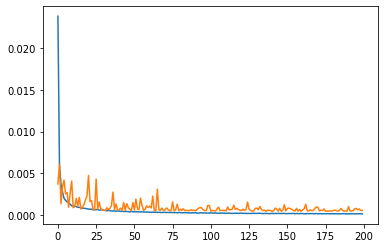

In [22]:
# Graph NN Error, mae and mse
plt.plot(ynnhistory.history['loss'])
plt.plot(ynnhistory.history['val_loss'])

**Yunzhou's Neural Net Model WITHOUT Mobility Data**

In [28]:
# Get data
X_YNN_nomob, y_YNN_nomob = get_YNN_states_dataset(state_cases_df, n_steps=N_STEPS)
X_train_YNN_nomob, X_test_YNN_nomob, y_train_YNN_nomob, y_test_YNN_nomob = train_test_split(X_YNN_nomob, y_YNN_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_ynn_features = X_train_YNN_nomob.shape[1]
ynn_nomob = build_YNN_model(n_ynn_features)

# Fit CNN
ynn_nomob_history = ynn_nomob.fit(X_train_YNN_nomob, y_train_YNN_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_YNN_nomob, y_test_YNN_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 0s 67us/sample - loss: 0.0180 - mean_absolute_error: 0.0689 - mean_squared_error: 0.0180 - val_loss: 0.0091 - val_mean_absolute_error: 0.0493 - val_mean_squared_error: 0.0091
Epoch 2/200
4222/4222 [==============================] - 0s 36us/sample - loss: 0.0117 - mean_absolute_error: 0.0525 - mean_squared_error: 0.0117 - val_loss: 0.0077 - val_mean_absolute_error: 0.0459 - val_mean_squared_error: 0.0077
Epoch 3/200
4222/4222 [==============================] - 0s 37us/sample - loss: 0.0101 - mean_absolute_error: 0.0471 - mean_squared_error: 0.0101 - val_loss: 0.0072 - val_mean_absolute_error: 0.0440 - val_mean_squared_error: 0.0072
Epoch 4/200
4222/4222 [==============================] - 0s 37us/sample - loss: 0.0090 - mean_absolute_error: 0.0444 - mean_squared_error: 0.0090 - val_loss: 0.0055 - val_mean_absolute_error: 0.0369 - val_mean_squared_error: 0.0055
Epoch 5/200
4222/4222 [=

Epoch 36/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0028 - mean_absolute_error: 0.0222 - mean_squared_error: 0.0028 - val_loss: 0.0065 - val_mean_absolute_error: 0.0428 - val_mean_squared_error: 0.0065
Epoch 37/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0028 - mean_absolute_error: 0.0224 - mean_squared_error: 0.0028 - val_loss: 0.0060 - val_mean_absolute_error: 0.0370 - val_mean_squared_error: 0.0060
Epoch 38/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0032 - mean_absolute_error: 0.0229 - mean_squared_error: 0.0032 - val_loss: 0.0023 - val_mean_absolute_error: 0.0270 - val_mean_squared_error: 0.0023
Epoch 39/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0030 - mean_absolute_error: 0.0229 - mean_squared_error: 0.0030 - val_loss: 0.0070 - val_mean_absolute_error: 0.0440 - val_mean_squared_error: 0.0070
Epoch 40/200
4222/4222 [==============================] - 0s 31us/sa

4222/4222 [==============================] - 0s 33us/sample - loss: 0.0018 - mean_absolute_error: 0.0171 - mean_squared_error: 0.0018 - val_loss: 0.0025 - val_mean_absolute_error: 0.0258 - val_mean_squared_error: 0.0025
Epoch 107/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0021 - mean_absolute_error: 0.0193 - mean_squared_error: 0.0021 - val_loss: 0.0022 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0022
Epoch 108/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0020 - mean_absolute_error: 0.0179 - mean_squared_error: 0.0020 - val_loss: 0.0033 - val_mean_absolute_error: 0.0275 - val_mean_squared_error: 0.0033
Epoch 109/200
4222/4222 [==============================] - 0s 34us/sample - loss: 0.0020 - mean_absolute_error: 0.0187 - mean_squared_error: 0.0020 - val_loss: 0.0026 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0026
Epoch 110/200
4222/4222 [==============================] - 0s 33us/sample - lo

4222/4222 [==============================] - 0s 33us/sample - loss: 0.0019 - mean_absolute_error: 0.0185 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0019
Epoch 177/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0017 - mean_absolute_error: 0.0178 - mean_squared_error: 0.0017 - val_loss: 0.0038 - val_mean_absolute_error: 0.0327 - val_mean_squared_error: 0.0038
Epoch 178/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0016 - mean_absolute_error: 0.0175 - mean_squared_error: 0.0016 - val_loss: 0.0028 - val_mean_absolute_error: 0.0254 - val_mean_squared_error: 0.0028
Epoch 179/200
4222/4222 [==============================] - 0s 31us/sample - loss: 0.0017 - mean_absolute_error: 0.0177 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_absolute_error: 0.0258 - val_mean_squared_error: 0.0018
Epoch 180/200
4222/4222 [==============================] - 0s 33us/sample - lo

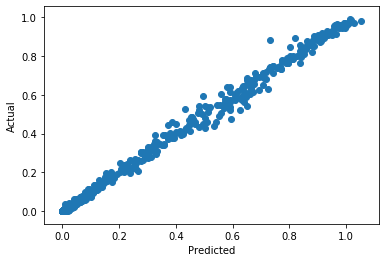

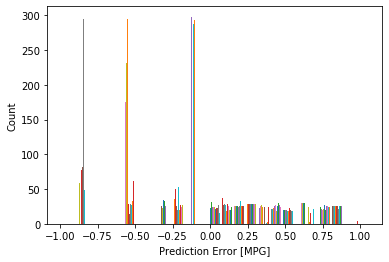

0.004527903903583825

In [51]:
# From the predicted vs. actual, we can see that the values are fitted pretty well
test_pred = ynn.predict(X_test_YNN)
plt.scatter(test_pred, y_test_YNN)
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

# The errors seem to have much normality, but a bit right-skewed
errors = test_pred - y_test_YNN
plt.hist(errors, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

# And the residuals mean is close to zero. 
np.mean(errors)

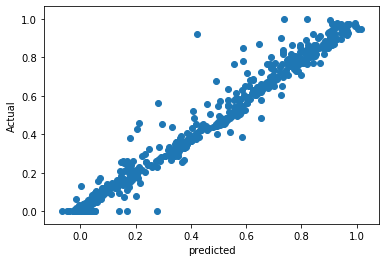

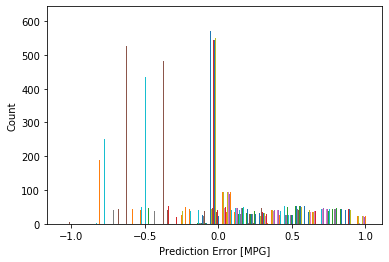

-0.007992969348711363

In [50]:
# Still, we can see that the predicted is pretty close to the actual, 
# but with less precisions as the model with Mobility data
test_ynn2 = ynn_nomob.predict(X_test_YNN_nomob)
plt.scatter(test_ynn2, y_test_YNN_nomob)
plt.xlabel("predicted")
plt.ylabel("Actual")
plt.show()

# Errors shows much normality, but seems to have a little right-skewed
errors2 = test_ynn2 - y_test_YNN_nomob
plt.hist(errors2, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

# And the error mean is pretty closed to zero
np.mean(errors2)

(26,)